In [43]:
import rpy2
import rpy2.robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [44]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import scipy.stats

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [45]:
import os
import sys

nb_dir_1 = os.path.split(os.getcwd())[0]
current_path = os.getcwd()
parent = os.path.dirname(current_path)
nb_dir_2 = os.path.split(parent)[0]

if nb_dir_1 not in sys.path:
    sys.path.append(nb_dir_1)

if nb_dir_2 not in sys.path:
    sys.path.append(nb_dir_2)

In [46]:
from core.data_preparation import DataPreparation
from core.models import LSTM

In [47]:
# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

In [48]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [49]:
filepath = "../Data/MRF_Stock_Close.csv"
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2005-01-03,2542.550049
1,2005-01-04,2550.050049
2,2005-01-05,2577.300049
3,2005-01-06,2512.550049
4,2005-01-07,2498.949951


In [50]:
data.tail()

,date,close
4216,2022-01-21,72697.10156
4217,2022-01-24,71077.35156
4218,2022-01-25,70569.95313
4219,2022-01-27,70712.64844
4220,2022-01-28,71327.70313


In [51]:
data['close'].isnull().values.any()

True

In [52]:
nan_rows = data[data['close'].isnull()]

In [53]:
nan_rows

,date,close
1258,2010-02-06,NaN
1736,2012-01-07,NaN
1775,2012-03-03,NaN
1905,2012-09-08,NaN
1947,2012-11-11,NaN
2284,2014-03-22,NaN
2513,2015-02-28,NaN


In [54]:
import calendar

def findDay():
    for date in nan_rows['date']:
        print(date)
        print(calendar.day_name[date.weekday()])
 
findDay()

2010-02-06 00:00:00
Samstag
2012-01-07 00:00:00
Samstag
2012-03-03 00:00:00
Samstag
2012-09-08 00:00:00
Samstag
2012-11-11 00:00:00
Sonntag
2014-03-22 00:00:00
Samstag
2015-02-28 00:00:00
Samstag


In [55]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [56]:
data['close'].isnull().values.any()

False

In [57]:
len(data)

4214

In [58]:
data.index

RangeIndex(start=0, stop=4214, step=1)

In [59]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Closing price in INR')

In [60]:
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [61]:
train_set, test_set = prep.splitData(data['close'].values)

In [62]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['close'].values, scaler)

x_train.shape =  (3351, 20, 1)
y_train.shape =  (3351, 1)
x_test.shape =  (823, 20, 1)
y_test.shape =  (823, 1)


In [63]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step() 

In [64]:
torch.save(model,'lstm_mrf.pt')

In [65]:
len(test_set)

843

In [66]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

preds = y_test_pred[:, 0]
gt = y_test[:, 0]

Test Score: 0.02 MAPE
R-squared value is 0.9425788046685755
RMSE:  2456.9698817852855


#### Measure how accuracy of model changes with shift in test set

In [67]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(8):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = (mean_absolute_percentage_error(X1, X2)) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*100} : {(i+1)*100}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df = pd.DataFrame(accuracy)

In [68]:
acc_df

,range,RMSE,MAPE,R2-score
0,0 : 100,2009.510886,2.615179,0.706359
1,100 : 200,1311.578057,1.851744,0.410469
2,200 : 300,1528.501636,1.879203,0.809409
3,300 : 400,2328.894695,2.715578,0.823811
4,400 : 500,1544.500890,2.081580,0.683313
5,500 : 600,4668.486264,4.271531,0.769778
6,600 : 700,2532.150469,2.490925,0.061492
7,700 : 800,2169.999539,1.953534,0.610871


In [69]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(11):
    
    X1, X2 = gt[i*70 : (i+1)*70], preds[i*70 : (i+1)*70]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = (mean_absolute_percentage_error(X1, X2)) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*70} : {(i+1)*70}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df2 = pd.DataFrame(accuracy)

In [70]:
acc_df2

,range,RMSE,MAPE,R2-score
0,0 : 70,1641.199561,2.052163,0.395728
1,70 : 140,2082.176505,2.914858,0.653722
2,140 : 210,1108.643766,1.524264,0.147282
3,210 : 280,1711.482837,2.123453,0.653997
4,280 : 350,1403.890176,1.712163,0.807993
5,350 : 420,2618.170163,3.186421,0.294722
6,420 : 490,1568.968132,2.122281,0.721034
7,490 : 560,2331.222962,2.438257,0.907366
8,560 : 630,5426.678726,5.098624,-0.745152
9,630 : 700,2378.418592,2.407145,-0.569072


In [71]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(16):
    
    X1, X2 = gt[i*50 : (i+1)*50], preds[i*50 : (i+1)*50]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = (mean_absolute_percentage_error(X1, X2)) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*50} : {(i+1)*50}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df3 = pd.DataFrame(accuracy)

In [72]:
acc_df3

,range,RMSE,MAPE,R2-score
0,0 : 50,1792.069474,2.215481,0.289713
1,50 : 100,2205.618847,3.014879,0.777432
2,100 : 150,1545.274409,2.218628,0.429121
3,150 : 200,1025.963693,1.484860,-0.110322
4,200 : 250,1830.310083,2.200267,0.699899
5,250 : 300,1150.043477,1.558138,-0.393479
6,300 : 350,1494.007363,1.765411,0.602017
7,350 : 400,2935.207318,3.665746,0.064751
8,400 : 450,1663.246374,2.101575,0.497391
9,450 : 500,1415.831160,2.061586,0.086500


In [73]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(27):
    
    X1, X2 = gt[i*30 : (i+1)*30], preds[i*30 : (i+1)*30]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = (mean_absolute_percentage_error(X1, X2)) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*30} : {(i+1)*30}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df4 = pd.DataFrame(accuracy)

#### ECDF distance measures between train set and test set

In [74]:
def get_statistical_dist_measures(X_train, X_test):   

    CVM_distance = Cramer_Von_Mises_Dist(X_train, X_test)
    Anderson_Darling_distance = Anderson_Darling_Dist(X_train, X_test)
    Kolmogorov_Smirnov_distance = Kolmogorov_Smirnov_Dist(X_train, X_test)
    Kuiper_distance = Kuiper_Dist(X_train, X_test)
    Wasserstein_distance = Wasserstein_Dist(X_train, X_test)
    DTS_distance = DTS_Dist(X_train, X_test)   
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [75]:
test_set_range = []
finalResult = []

for i in range(8):
    
    X1, X2 = train_set, gt[i*100 : (i+1)*100]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult.append(distances)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



In [76]:
test_set_range = []
finalResult2 = []

for i in range(11):
    
    X1, X2 = train_set, gt[i*70 : (i+1)*70]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult2.append(distances)
    test_set_range.append(f'{i*70} : {(i+1)*70}')



In [77]:
df = pd.DataFrame(finalResult)
# df.insert(0, 'Test set range', test_set_range)
frames = [acc_df[['RMSE',  'R2-score', ]], df]
df = pd.concat(frames, axis=1)
df

#As distance between train and test increases, model's performance decreases. We should analyse this point here.
# Only DTS_dist and Wasserstein_dist are positively correlated to model's accuracy.

,RMSE,R2-score,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,2009.510886,0.706359,57.911023,1444.335111,1908.584096,0.891724,0.949273,44668.312352
1,1311.578057,0.410469,55.171259,1394.586322,1587.093533,0.885197,0.989321,38363.294355
2,1528.501636,0.809409,56.052252,1411.156233,1777.306126,0.889647,0.966775,42122.911762
3,2328.894695,0.823811,58.127383,1445.466055,1881.813583,0.881637,0.912489,43963.163192
4,1544.500890,0.683313,55.966348,1409.803388,1791.507449,0.892613,0.965292,42466.977727
5,4668.486264,0.769778,75.142140,1650.351029,3368.437122,0.893800,0.893800,58877.756674
6,2532.150469,0.061492,80.890339,1725.588635,3346.648054,0.988134,0.988134,61711.088979
7,2169.999539,0.610871,78.085271,1695.831323,3009.245859,0.947790,0.947790,58215.890307


In [78]:
df1 = pd.DataFrame(finalResult2)
df1.insert(0, 'Test set range', test_set_range)
df1

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,58.606892,1445.392897,2012.183818,0.897656,0.955206,46034.546281
1,70 : 140,55.110294,1383.627186,1684.597181,0.891724,0.965292,39839.511448
2,140 : 210,54.991881,1380.826529,1579.039456,0.885197,0.991694,37749.082138
3,210 : 280,56.045833,1400.374281,1824.683990,0.891724,0.968852,42509.861935
4,280 : 350,60.305894,1471.034737,2086.776285,0.898250,0.929101,47227.481492
5,350 : 420,55.220993,1385.637386,1735.058213,0.881637,0.954316,40807.729778
6,420 : 490,56.082101,1401.011790,1828.484452,0.892613,0.965292,42594.380172
7,490 : 560,68.270440,1551.464784,2451.518440,0.893800,0.894393,50659.919349
8,560 : 630,82.269171,1713.240323,4170.855050,0.992880,0.992880,66415.318912
9,630 : 700,81.830996,1709.667644,3360.806007,0.988134,0.988134,60885.644470


In [79]:
frames = [acc_df2[['RMSE',  'R2-score', 'MAPE']], df1.iloc[:, 1:]]
df2 = pd.concat(frames, axis=1)
df2


,RMSE,R2-score,MAPE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,1641.199561,0.395728,2.052163,58.606892,1445.392897,2012.183818,0.897656,0.955206,46034.546281
1,2082.176505,0.653722,2.914858,55.110294,1383.627186,1684.597181,0.891724,0.965292,39839.511448
2,1108.643766,0.147282,1.524264,54.991881,1380.826529,1579.039456,0.885197,0.991694,37749.082138
3,1711.482837,0.653997,2.123453,56.045833,1400.374281,1824.683990,0.891724,0.968852,42509.861935
4,1403.890176,0.807993,1.712163,60.305894,1471.034737,2086.776285,0.898250,0.929101,47227.481492
5,2618.170163,0.294722,3.186421,55.220993,1385.637386,1735.058213,0.881637,0.954316,40807.729778
6,1568.968132,0.721034,2.122281,56.082101,1401.011790,1828.484452,0.892613,0.965292,42594.380172
7,2331.222962,0.907366,2.438257,68.270440,1551.464784,2451.518440,0.893800,0.894393,50659.919349
8,5426.678726,-0.745152,5.098624,82.269171,1713.240323,4170.855050,0.992880,0.992880,66415.318912
9,2378.418592,-0.569072,2.407145,81.830996,1709.667644,3360.806007,0.988134,0.988134,60885.644470


In [80]:
test_set_range = []
finalResult3 = []

for i in range(16):
    
    X1, X2 = train_set, gt[i*50 : (i+1)*50]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult3.append(distances)
    test_set_range.append(f'{i*50} : {(i+1)*50}')



In [81]:
df3 = pd.DataFrame(finalResult3)
df3.insert(0, 'Test set range', test_set_range)
df3.head()

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 50,57.946299,1426.231083,2003.792376,0.897656,0.961436,45435.333785
1,50 : 100,57.701451,1421.268389,1928.851971,0.891724,0.949273,43939.422063
2,100 : 150,55.034131,1374.645435,1647.844156,0.885197,0.989321,38771.550995
3,150 : 200,55.038672,1374.757111,1620.572737,0.890537,0.997034,38253.332562
4,200 : 250,54.928805,1373.265802,1693.373928,0.889647,0.966775,39658.151367


In [82]:
test_set_range = []
finalResult4 = []

for i in range(27):
    
    X1, X2 = train_set, gt[i*30 : (i+1)*30]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult4.append(distances)
    test_set_range.append(f'{i*30} : {(i+1)*30}')



In [83]:
df4 = pd.DataFrame(finalResult4)
df4.insert(0, 'Test set range', test_set_range)
df4.head()

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 30,56.880064,1400.392327,1975.886163,0.897656,0.973598,44500.129126
1,30 : 60,60.046866,1453.416286,2148.624428,0.913082,0.970632,47443.906178
2,60 : 90,58.276041,1423.349768,2036.790544,0.894690,0.967665,45491.159467
3,90 : 120,55.078975,1368.399071,1677.820850,0.891724,0.997330,39006.379487
4,120 : 150,54.914361,1365.318669,1649.356314,0.885197,0.989321,38462.653264


In [84]:
mape2 = 100 - acc_df2['MAPE']

In [85]:
fig = px.scatter(x=df2['Wasserstein_dist'], y=mape2, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (100-MAPE)"),
                        title="Plot showing behaviour of Performance measured as 100-MAPE vs. Wasserstein distance measure")
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [86]:
fig = px.scatter(x=df2['DTS_dist'], y=mape2, labels=dict(x="Dissimilarity (DTS distance)", y="Accuracy (100 - MAPE)"),
                        title="Plot showing behaviour of Performance measured as 100-MAPE vs. DTS distance measure")
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [87]:
fig = px.scatter(x=df2['DTS_dist'], y=df2['RMSE'], labels=dict(x="Dissimilarity (DTS distance)", y="Performance (RMSE)"),
                    title="Plot showing behaviour of Performance measured using RMSE vs. DTS distance measure")
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [88]:
fig = px.scatter(x=df2['Wasserstein_dist'], y=df2['RMSE'], labels=dict(x="Dissimilarity (Wasserstein distance)", y="Performance (RMSE)"),
                    title="Plot showing behaviour of Performance measured using RMSE vs. Wasserstein distance measure")
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [89]:
mape4 = 100 - acc_df4['MAPE']

In [90]:
fig = px.scatter(x=df4['Wasserstein_dist'], y=mape4, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (100-MAPE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

### Curve fitting using np.polyfit()

In [91]:
def fit_polynomial_curve_to_data_and_visualize(x, y, degree=2, interpolation=100, xlabel='Distance', ylabel='Performance'):

    z = np.polyfit(x, y, degree)

    fit = np.poly1d(z)

    x_min = x.min()
    x_max = x.max()

    xp = np.linspace(x_min, x_max, interpolation)
    yp = fit(xp)

    #Plotting
    fig1 = plt.figure()
    ax1 = fig1.subplots()
    ax1.plot(xp, yp, color = 'r',alpha = 0.5, label = 'Polynomial fit')
    ax1.scatter(x, y, s = 5, color = 'b', label = 'Data points')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title('Polynomial fit for given (x,y) data points')
    ax1.legend()
    plt.show()



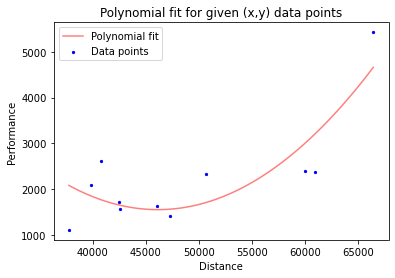

In [92]:
x = np.array(df2['Wasserstein_dist'].values)
y = np.array(df2['RMSE'].values)

fit_polynomial_curve_to_data_and_visualize(x, y, 2)

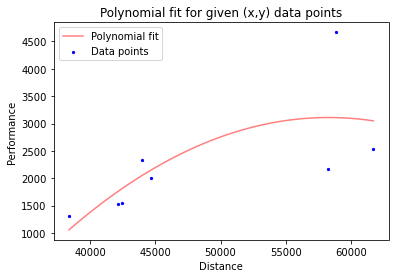

In [98]:
x = np.array(df['Wasserstein_dist'].values)
y = np.array(acc_df['RMSE'].values)

fit_polynomial_curve_to_data_and_visualize(x, y, 2)

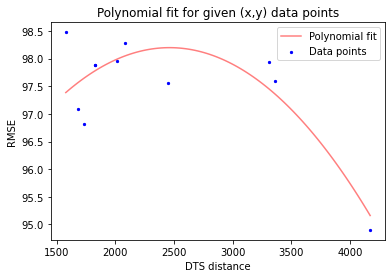

In [93]:
x1 = np.array(df2['DTS_dist'].values)
y1 = np.array(mape2)

fit_polynomial_curve_to_data_and_visualize(x1, y1, xlabel='DTS distance', ylabel='RMSE')

In [95]:
df2.to_csv('MRF_results.csv', index=False)